# Super-Resolution and Restoration of images (Image-to-Image task)
## Rosato Marco - University of Milano Bicocca

"**Image Super-Resolution and Restoration**" refers to techniques that enhance low-quality images by increasing their resolution (making them sharper and more detailed) and removing degradations like blur and noise.
For this project, I utilized the [IAPR TC-12](https://www.imageclef.org/photodata) dataset. While typically used for image-text association, its diverse collection of 20000 *JPEG* images with varying resolutions proved suitable for this super-resolution and restoration task.

To generate the necessary paired data, original High-Resolution (HR) images were synthetically degraded to create corresponding Low-Resolution (LR) counterparts.  
Using these pairs, I trained and evaluated two distinct U-Net architectures—one base model and a more complex variant. I tested different loss function: Mean Absolute Error (MAE) was used as a pixel-wise loss and a combined loss (MAE + perceptual loss). To further analyze the impact of the perceptual component, features were extracted from two different levels of a pre-trained VGG19 network:
* Block2 - Conv2 (early-level features)
* Block5 - Conv4 (high-level features)

Finally, inference was performed with each trained model, allowing for a visual comparison of their reconstruction capabilities on random patches from the test dataset.

In [ ]:
import os
import glob
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import load_model
from tensorflow.keras import metrics

2025-06-09 03:54:09.582709: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749441249.923338      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749441250.004272      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# --- 1 Configuration
# 1.1 Seeds
np.random.seed(2077)
tf.random.set_seed(2077)
random.seed(2077)

# 1.2 Patch dimensions for High-Resolution (HR) and Low-Resolution (LR) images
PATCH_H = 256                          # Height of the HR image patches
PATCH_W = 256                          # Width of the HR image patches
PATCH_LR_H = PATCH_H // 2              # Height of the LR image patches (128)
PATCH_LR_W = PATCH_W // 2              # Width of the LR image patches (128)
UPSCALE = PATCH_H // PATCH_LR_H        # scale factor (2x super-resolution)
CH = 3                                 # RGB

# 1.3 Training
BATCH_SIZE      = 8
EPOCHS          = 50
SAMPLE_SIZE     = None                 # None = full data

## Data Collection and Initial Exploration
This section handles gathering image paths from the dataset, splitting them into training, validation, and test sets, and performs an initial check on image dimensions.

The IAPR TC-12 dataset is organized into 41 subfolders (00 to 40)

In [ ]:
# --- 2 Collection of image paths
base_folder = '/kaggle/input/iaprtc12/images'
all_paths = []

for i in range(0, 41):
    folder_name = f"{i:02d}"                                # This is done for the first 10 folder ("0" -> "00", "1" -> "01",...)
    full_folder = os.path.join(base_folder, folder_name)

    pattern = os.path.join(full_folder, f"*.jpg")           # All the images are jpg format
    for f in glob.glob(pattern):
         if os.path.getsize(f) > 0:                         # Ensure that each file is not empty (>0)
            all_paths.append(f)

train_paths, test_paths = train_test_split(all_paths, test_size=0.15, random_state=2077)     # 15% of the whole data for test
train_paths, val_paths  = train_test_split(train_paths, test_size=0.2, random_state=2077)    # 20% of the remaning for validation

print(f"In the dataset there are 20000 images, I was able to identify {len(all_paths)} images.")
print(f"Of these {len(all_paths)} image, {len(train_paths)} will be used for training, {len(val_paths)} will used for validation and {len(test_paths)} will be used for test.")

In the dataset there are 20000 images, I was able to identify 20000 images.
Of these 20000 image, 13600 will be used for training, 3400 will used for validation and 3000 will be used for test.


In [ ]:
# --- 3 Minimum height and witdh between all images.
# This step helps to understand the variability in image sizes and ensure that the chosen patch size (256x256) is feasible
# by checking if all original images are at least as large as the desired patch size.
min_height = np.inf
min_width  = np.inf

for path in all_paths:
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)      # Read image by keeping its original channel count
    if img is None:
        print(f"Can't read this image: {path}")
        continue

    h, w = img.shape[:2]                              #Get height and width
    if h < min_height:
        min_height = h
    if w < min_width:
        min_width = w

if min_height == np.inf or min_width == np.inf:
    print("No valid image")
else:
    print(f"Minimum hight between all images : {min_height}")
    print(f"Minimum width between all images : {min_width}")

Can't read this image: /kaggle/input/iaprtc12/images/17/17975.jpg
Can't read this image: /kaggle/input/iaprtc12/images/19/19579.jpg
Can't read this image: /kaggle/input/iaprtc12/images/19/19575.jpg
Minimum hight between all images : 320
Minimum width between all images : 320


## Data Degradation and Preprocessing
This section defines the synthetic degradation process to create LR images from HR images and sets up the data pipeline for loading and augmentation.

In [ ]:
# --- 4 Degratation function (HR patch 256x256 -> LR patch 128x128)
# This function simulates image degradation by downsampling, blurring and adding noise.
def degrade(hr_patch):

    hr = hr_patch.numpy() if hasattr(hr_patch, 'numpy') else hr_patch           # Convert to NumPy array if it is not
    img = (hr * 255.0).astype(np.float32)                                       # Denormalize to [0-255] for next steps

    # 4.1 Downsample 2x using "INTER_AREA" interpolation
    small = cv2.resize(img, (PATCH_LR_W, PATCH_LR_H), interpolation=cv2.INTER_AREA)
    # 4.2 Gaussian Blur
    small = cv2.GaussianBlur(small, (5,5), 1.0)
    # 4.3 Gaussian Noise
    noise = np.random.normal(0, 10, small.shape).astype(np.float32)

    small = small + noise
    # 4.4 Clip values to [0-255] and then Normalize to [0-1]. "Clip" is done because previous degradation steps can change values to >255 or <0
    small = np.clip(small, 0.0, 255.0) / 255.0
    return small.astype(np.float32)

Path of a random HR image: /kaggle/input/iaprtc12/images/35/35888.jpg


I0000 00:00:1749441418.626853      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


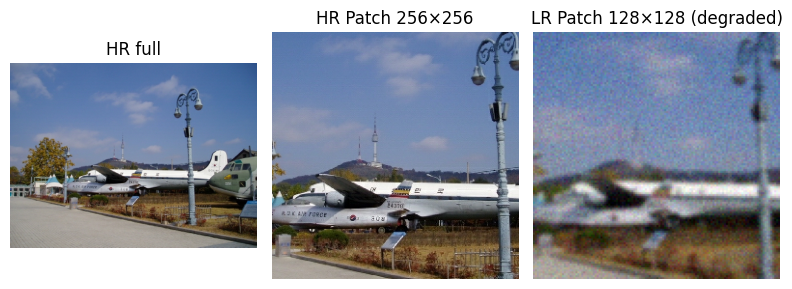

In [ ]:
# --- 5 Visualization of the degradation function

# 5.1 Select a random image from train
random_path = random.choice(train_paths)
print(f"Path of a random HR image: {random_path}")

# 5.2 Read the full HR image
hr_full = tf.io.decode_jpeg(tf.io.read_file(random_path), channels=CH)
hr_full = tf.image.convert_image_dtype(hr_full, tf.float32)                     # Normalize to [0,1]

# 5.3 Extract a central HR patch (256x256)
hr_patch = tf.image.resize_with_crop_or_pad(hr_full, PATCH_H, PATCH_W)
hr_patch = hr_patch.numpy()                                                     # Convert to NumPy for the "degrade" function

# 5.4 Applaying degradation function
lr_patch = degrade(hr_patch)                                                    # This will produce [128,128,3] LR patch

# 5.5 Visualization
plt.figure(figsize=(8,4))

plt.subplot(1,3,1)
plt.title("HR full")
plt.imshow(hr_full)
plt.axis('off')

plt.subplot(1,3,2)
plt.title("HR Patch 256×256")
plt.imshow(hr_patch)
plt.axis('off')

plt.subplot(1,3,3)
plt.title("LR Patch 128×128 (degraded)")
plt.imshow(lr_patch)
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# --- 6 Data loading and preprocessing function
def load_and_preprocess(path, training):

    # 6.1 Read and decode HR image
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=CH)                                    # Decode JPEG to tensor with CH channels
    img = tf.image.convert_image_dtype(img, tf.float32)                          # Convert to float32 and Normalize [0-1]

    # 6.2 Extract HR 256×256 patch
    if training:
        # 6.2.1 Data Augmentation for better training
        hr_patch = tf.image.random_crop(img, [PATCH_H, PATCH_W, CH])             # Random crop a patch (256*256)
        hr_patch = tf.image.random_flip_left_right(hr_patch)                     # Random Left or righ flip
        k = tf.random.uniform([], 0, 4, tf.int32)                                # Random choice of 90° rotation (0, 90, 180,270)
        hr_patch = tf.image.rot90(hr_patch, k)                                   # Applying the random rotation
    else:
        # 6.2.2 Central Crop 256×256 for non-Training data (val/test). (images are guaranteed to be larger, so padding will never be applied).
        hr_patch = tf.image.resize_with_crop_or_pad(img, PATCH_H, PATCH_W)

    # 6.3 lr_patch generated through degrade
    lr_patch = tf.py_function(func=degrade, inp=[hr_patch], Tout=tf.float32)    # Apply "degrade" function to "hr_patch" to generate che corrisponging "lr_patch"
    lr_patch.set_shape([PATCH_LR_H, PATCH_LR_W, CH])                            # Static shape to avoid inference issues
    hr_patch.set_shape([PATCH_H, PATCH_W, CH])

    return lr_patch, hr_patch                                                   # the "matched" pair LR and HR is created

In [ ]:
# --- 7 Dataset creation
def make_dataset(paths, training):

    ds = tf.data.Dataset.from_tensor_slices(paths)
    if training:
        ds = ds.shuffle(buffer_size=len(paths))               # shuffle training data for randomness
    ds = ds.map(lambda p: load_and_preprocess(p, training),   # Map the "load_and_preprocess" function to each element in the dataset
                num_parallel_calls=tf.data.AUTOTUNE)          # "tf.data.AUTOTUNE" is used for better performance
    ds = ds.batch(BATCH_SIZE)                                 # Create Batch of the preprocessed elements
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

if SAMPLE_SIZE is not None:                                   # For debug
    train_paths = train_paths[:SAMPLE_SIZE]
    val_paths   = val_paths[:SAMPLE_SIZE//5]
    test_paths  = test_paths[:SAMPLE_SIZE//5]

train_ds = make_dataset(train_paths, training=True)           # Create training
val_ds   = make_dataset(val_paths,   training=False)          # Create validation
test_ds  = make_dataset(test_paths,  training=False)          # Create test

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

print(train_ds)
print(val_ds)
print(test_ds)

Train: 13600, Val: 3400, Test: 3000
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>


## Model Architectures
The U-Net is a powerful convolutional neural network characterized by its U-shaped encoder-decoder architecture. Its unique feature are the skip connections: they connect encoder layers with corresponding decoder layers, allowing the recovery of spatial information lost during the downsampling phase.

This section defines the two U-Net models used: a basic U-Net and an advanced U-Net with additional features like Conv2DTranspose, Batch Normalization, LeakyReLU and Residual Skip connections.

In [ ]:
# --- 8.1 Base U-NET model
# This U-NET uses Conv2D (convolutional layers) with ReLu activation function, MaxPooling2D (for downsampling),
# UpSampling2D (for upsampling) and Concatenate (skip connection)
def build_unet_sr():
    inputs = layers.Input((PATCH_LR_H, PATCH_LR_W, CH))                                                 # The input is the LR patch 128×128x3

    # Encoder (for Downsampling)
    c1 = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    c1 = layers.Conv2D(64, 3, padding='same', activation='relu')(c1)
    p1 = layers.MaxPooling2D()(c1)                                                                      # Downsample to 64×64
    c2 = layers.Conv2D(128, 3, padding='same', activation='relu')(p1)
    c2 = layers.Conv2D(128, 3, padding='same', activation='relu')(c2)
    p2 = layers.MaxPooling2D()(c2)                                                                      # Downsample to 32×32

    # Bottleneck (lowest part of the U-Net)
    b1 = layers.Conv2D(256, 3, padding='same', activation='relu')(p2)
    b1 = layers.Conv2D(256, 3, padding='same', activation='relu')(b1)

    # Decoder (for Upsampling)
    t2 = layers.UpSampling2D(size=(UPSCALE, UPSCALE), interpolation='bilinear')(b1)                     # Upsample to 64x64
    t2 = layers.Concatenate()([t2, c2])
    c3 = layers.Conv2D(128, 3, padding='same', activation='relu')(t2)
    c3 = layers.Conv2D(128, 3, padding='same', activation='relu')(c3)
    t1 = layers.UpSampling2D(size=(UPSCALE, UPSCALE), interpolation='bilinear')(c3)                     # Upsample to 128x128
    t1 = layers.Concatenate()([t1, c1])
    c4 = layers.Conv2D(64, 3, padding='same', activation='relu')(t1)
    c4 = layers.Conv2D(64, 3, padding='same', activation='relu')(c4)

    # Final upsample to target HR patch size 256x256
    up = layers.UpSampling2D(size=(UPSCALE, UPSCALE), interpolation='bilinear')(c4)                     # Upsample to 256x256
    # Output -> Final Conv2D layer to produce 3 channels colours (RGB)
    outputs = layers.Conv2D(CH, 1, padding='same', activation='sigmoid')(up)
    return keras.Model(inputs, outputs, name="UNet_SR_2x")

model_base_first1 = build_unet_sr()
model_base_first1.summary()

Model: "UNet_SR_2x"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 64, 64, 256)    │              0 │ conv2d_5[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 384)    │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 128)    │        442,496 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 128, 128, 128)  │              0 │ conv2d_7[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 128, 128, 192)  │              0 │ up_sampling2d_1[0][0], │
│ (Concatenate)             │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 128, 128, 64)   │        110,656 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)    

 Total params: 1,883,267 (7.18 MB)

 Trainable params: 1,883,267 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- 8.2 Advance U-Net
# This U-Net uses Conv2D (convolutional layers), LeakyReLu activation function (to prevent dying ReLu), Strides (parametric downsampling), BatchNormalization,
# Residual skip connection (to reduce vanishing gradient), Conv2DTranspose and Concatenate
def build_advanced_unet():
    inputs = layers.Input((PATCH_LR_H, PATCH_LR_W, CH))                           # The input is the LR patch 128×128x3

     # Initial Convolution Block
    s0 = layers.Conv2D(64, 3, padding='same', use_bias=False)(inputs)   # "use_bias=False" because BatchNormalization adds its own bias.
    s0 = layers.BatchNormalization()(s0)
    s0 = layers.LeakyReLU(0.1)(s0)

    # Encoder
    def enc_block(x, filters):
        x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(0.1)(x)
        x = layers.Conv2D(filters, 3, strides=2, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(0.1)(x)
        return x

    e1 = enc_block(s0, 64)                                                         # Downsample to 64×64
    e2 = enc_block(e1, 128)                                                        # Downsample to 32x32

    # Bottleneck
    b = layers.Conv2D(256, 3, padding='same', use_bias=False)(e2)
    b = layers.BatchNormalization()(b)
    b = layers.LeakyReLU(0.1)(b)
    residual = layers.Conv2D(256, 3, padding='same', use_bias=False)(b)
    residual = layers.BatchNormalization()(residual)
    b = layers.Add()([b, residual])   # Add residual connection
    b = layers.LeakyReLU(0.1)(b)

    # Decoder
    def dec_block(x, skip, filters):
        x = layers.Conv2DTranspose(filters, 3, strides=2, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Concatenate()([x, skip])
        x = layers.LeakyReLU(0.1)(x)
        x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(0.1)(x)

        return x

    d2 = dec_block(b, e1, 128)                                                    # Upsample to 64x64
    d1 = dec_block(d2, s0, 64)                                                    # Upsample to 128x128

    # Final upsample to target HR patch size 256x256
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', use_bias=False)(d1)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)

    # output -> Final Conv2D layer to produce 3 channels colours (RGB)
    outputs = layers.Conv2D(3, 1, padding='same', activation='sigmoid')(x)

    return keras.Model(inputs, outputs, name="Advanced_UNet_SR")

model_adv_easyloss = build_advanced_unet()
model_adv_b5 = build_advanced_unet()
model_adv_b2 = build_advanced_unet()
model_adv_b5_alpha = build_advanced_unet()
model_adv_b5.summary()

Model: "Advanced_UNet_SR"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 128, 128, 64)   │          1,728 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 128, 128, 64)   │            256 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_12            │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 128, 128, 64)   │         36,864 │ leaky_re_lu_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 128, 128, 64)   │            256 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_13            │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 64, 64, 64)     │         36,864 │ leaky_re_lu_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 64, 64, 64)     │            256 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_14            │ (None, 64, 64, 64)     │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 64, 64, 128)    │         73,728 │ leaky_re_lu_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 64, 64, 128)    │            512 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_15            │ (None, 64, 64, 128)    │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 32, 32, 128)    │        147,456 │ leaky_re_lu_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 32, 32, 128)    │            512 │ conv2d_25[0][0]        │
│ (BatchNormalization) 

 Total params: 1,887,619 (7.20 MB)

 Trainable params: 1,884,803 (7.19 MB)

 Non-trainable params: 2,816 (11.00 KB)

## Loss Functions and Metrics
This section defines the loss functions used for training, including pixel-wise Mean Absolute Error (MAE) and a combined perceptual loss leveraging a pre-trained VGG19 network. Perceptual loss measures the difference between representations in feature spaces pushing the model to generate outputs that are visually similar to the ground truth. Unlike pixel-wise loss, which compares pixel values and can produce blurry results, perceptual loss captures high-level structures and semantic details.
Combining them allows to combine the benefits of both: pixel-wise loss provides local fidelity and numerical consistency, while perceptual loss improves visual quality and perceived similarity.


It also defines the evaluation metrics (PSNR and SSIM) that are ofter used in img2img task.

* PSNR: The higher is better [0,∞]. Good results are with PSNR > 30
* SSIM: The higher is better [-1,+1]. good results are with SSIM >0.5

In [ ]:
# --- 9 Loss Functions
pixel_loss = keras.losses.MeanAbsoluteError()

# 9.1 Base: Pixel-By-Pixel loss (MAE)
def mae_only_loss(y_true, y_pred):
    return pixel_loss(y_true, y_pred)


# 9.2 Advance: MAE + Perceptual (VGG19) loss
vgg = VGG19(include_top=False, weights='imagenet')   # "include_top=FALSE" to load VGG19 without classification layers
vgg.trainable = False                                # "trainable = False" to freeze its weight (I only want to extract feature)

# 9.2.1 Feature extraction from block5 conv4
feat_ext_block5_conv4 = keras.Model(
    inputs=vgg.input,
    outputs=vgg.get_layer('block5_conv4').output     # Deepest VGG19 layer (high-level features)
)

def perceptual_block5(y_true, y_pred):               # y_true (ground truth) and y_pred (output of the models) are in range [0-1]
    yt = preprocess_input(y_true * 255.0)            # Denormalize to [0-255] to enable "preprocess_input" function
    yp = preprocess_input(y_pred * 255.0)
    ft = feat_ext_block5_conv4(yt)                   # Extract feature from VGG19 for true and predicted images
    fp = feat_ext_block5_conv4(yp)
    return pixel_loss(ft, fp)                        # Pixel-wise loss to measure difference in the feature space




# 9.2.2 Feature extraction from block2 conv2
feat_ext_block2_conv2 = keras.Model(
    inputs=vgg.input,
    outputs=vgg.get_layer('block2_conv2').output    # Earlier VGG19 layer (entry-level features)
)

def perceptual_block2(y_true, y_pred):
    yt = preprocess_input(y_true * 255.0)
    yp = preprocess_input(y_pred * 255.0)
    ft = feat_ext_block2_conv2(yt)
    fp = feat_ext_block2_conv2(yp)
    return pixel_loss(ft, fp)




# 9.3 Combined loss

# 9.3.1 Combined loss with "block5 conv4" (MAE + Perceptual Loss) with alpha=0.005
def sr_loss_block5(y_true, y_pred):
    pixel_l = pixel_loss(y_true, y_pred)
    perceptual_l = perceptual_block5(y_true, y_pred)
    return pixel_l + 0.005 * perceptual_l      # a small weight is applied to perceptual loss because their values are usually higher than pixel-wise loss

# 9.3.2 Combined loss with "block2 conv2" with alpha=0.005
def sr_loss_block2(y_true, y_pred):
    pixel_l = pixel_loss(y_true, y_pred)
    perceptual_l = perceptual_block2(y_true, y_pred)
    return pixel_l + 0.005 * perceptual_l

# 9.3.3 Combined loss with "block5 conv4" with alpha=0.02
def sr_loss_block5_alpha(y_true, y_pred):
    pixel_l = pixel_loss(y_true, y_pred)
    perceptual_l = perceptual_block5(y_true, y_pred)
    return pixel_l + 0.02 * perceptual_l

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# --- 10 Callbacks
def create_standard_callbacks(checkpoint_path, patience_es=7, patience_lr=3):
    return [
        keras.callbacks.ModelCheckpoint(                                        # Save only the model with the best validation loss
            filepath=checkpoint_path,
            save_best_only=True,
            monitor='val_loss',
            verbose=1
        ),
        keras.callbacks.EarlyStopping(                                          # Stop training if there are not improvement
            patience=patience_es,
            restore_best_weights=True,
            monitor='val_loss',
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(                                      # Reduce learning rate to gain even small improvement
            factor=0.2,
            patience=patience_lr,
            min_lr=1e-6,                                                        # Minimum value that can reach the learning rate
            monitor='val_loss',
            verbose=1
        )
    ]

# 10.1 Checkpoint Position
CHECKPOINT_BASE_FIRST1 = 'checkpoint_base_first1.keras'
CHECKPOINT_ADV_EASYLOSS = 'checkpoint_adv_easyloss.keras'
CHECKPOINT_ADV_B5 = 'checkpoint_adv_block5.keras'
CHECKPOINT_ADV_B2 = 'checkpoint_adv_block2.keras'
CHECKPOINT_ADV_B5_ALPHA = 'checkpoint_adv_block5_alpha.keras'

# 10.2 callbacks creation
callbacks_base_first1 = create_standard_callbacks(CHECKPOINT_BASE_FIRST1)
callbacks_adv_easyloss = create_standard_callbacks(CHECKPOINT_ADV_EASYLOSS)
callbacks_adv_b5 = create_standard_callbacks(CHECKPOINT_ADV_B5)
callbacks_adv_b2 = create_standard_callbacks(CHECKPOINT_ADV_B2)
callbacks_adv_b5_alpha = create_standard_callbacks(CHECKPOINT_ADV_B5_ALPHA)

In [ ]:
# --- 11 Additional Metrics
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

In [ ]:
# --- 12 Plots (This is used to visualize training history by showing trends for loss, PSNR and SSIM)
def plot_three_metrics(history, title_prefix=""):
    epochs = range(1, len(history.history['loss']) + 1)
    loss_fn_name = history.model.loss.__name__
    clean_loss_name = loss_fn_name.replace('_', ' ').upper()

    plt.figure(figsize=(15,4))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history.history['loss'],      label=f'train {clean_loss_name}')
    plt.plot(epochs, history.history['val_loss'],  label=f'val {clean_loss_name}')
    plt.title(f'{title_prefix}{(" " + clean_loss_name) }')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.legend()

    # PSNR
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history.history['psnr_metric'],     label='train PSNR')
    plt.plot(epochs, history.history['val_psnr_metric'], label='val PSNR')
    plt.title(f'{title_prefix} PSNR')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR (dB)')
    plt.legend()

    # SSIM
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history.history['ssim_metric'],     label='train SSIM')
    plt.plot(epochs, history.history['val_ssim_metric'], label='val SSIM')
    plt.title(f'{title_prefix} SSIM')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Model Training
This section compiles and trains each of the defined U-Net models with different loss functions.

In [ ]:
# --- 13.1 Base U-Net with MAE
# This model uses the simpler U-Net architecture and is trained purely on Mean Absolute Error.
model_base_first1.compile(
    optimizer=keras.optimizers.Adam(5e-4),
    loss=mae_only_loss,
    metrics=[
        psnr_metric,
        ssim_metric,
        mae_only_loss
    ]
)

In [ ]:
# --- 13.2 Train Base U-Net with MAE
history_base1 = model_base_first1.fit(train_ds,
                              validation_data=val_ds,
                              epochs=EPOCHS,
                              callbacks=callbacks_base_first1)

Epoch 1/50


I0000 00:00:1749441431.308148      58 service.cc:148] XLA service 0x787708002ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749441431.309082      58 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1749441431.672088      58 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1749441431.672177      58 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1749441431.674001      58 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1749441431.674094      58 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1749441431.674496      58 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1749441431.674676      58 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_3/Assert
I0000 00:00:1749441431.922863      58 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/1700 ━━━━━━━━━━━━━━━━━━━━ 2:06 74ms/step - loss: 0.2121 - mae_only_loss: 0.2121 - psnr_metric: 12.3461 - ssim_metric: 0.4140  

I0000 00:00:1749441439.135188      58 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1700/1700 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0654 - mae_only_loss: 0.0654 - psnr_metric: 22.3172 - ssim_metric: 0.5986

W0000 00:00:1749441578.158178      59 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1749441578.158272      59 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1749441578.159909      59 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1749441578.159992      59 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1749441578.160261      59 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1749441578.160398      59 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_3/Assert



Epoch 1: val_loss improved from inf to 0.04090, saving model to checkpoint_base_first1.keras
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 172s 93ms/step - loss: 0.0654 - mae_only_loss: 0.0654 - psnr_metric: 22.3182 - ssim_metric: 0.5986 - val_loss: 0.0409 - val_mae_only_loss: 0.0409 - val_psnr_metric: 24.9072 - val_ssim_metric: 0.6606 - learning_rate: 5.0000e-04
Epoch 2/50
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0401 - mae_only_loss: 0.0401 - psnr_metric: 25.1014 - ssim_metric: 0.6715
Epoch 2: val_loss improved from 0.04090 to 0.03933, saving model to checkpoint_base_first1.keras
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 156s 91ms/step - loss: 0.0401 - mae_only_loss: 0.0401 - psnr_metric: 25.1014 - ssim_metric: 0.6715 - val_loss: 0.0393 - val_mae_only_loss: 0.0393 - val_psnr_metric: 25.2033 - val_ssim_metric: 0.6744 - learning_rate: 5.0000e-04
Epoch 3/50
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0388 - mae_only_loss: 0.0388 - psnr_metric: 25.3379 - ssim_metric: 0.6805
Epoch 3: val_lo

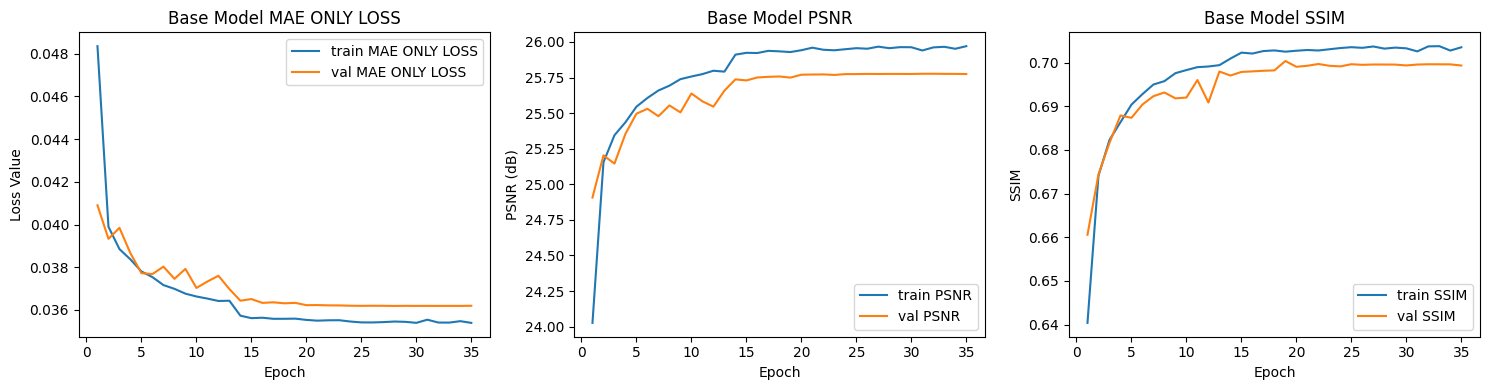

In [ ]:
# --- 13.3 Plots Train vs Val Base U-Net with MAE
plot_three_metrics(history_base1, title_prefix="Base Model")

In [ ]:
# --- 13.4 Save Base U-Net with MAE
model_base_first1.save('model_base_first_full1.keras')

In [ ]:
# --- 14.1 Advance U-Net with MAE
# This model uses the improved U-Net architecture but is still trained only on MAE, allowing us to isolate the architectural improvements' impact.
model_adv_easyloss.compile(
    optimizer=keras.optimizers.Adam(5e-4),
    loss=mae_only_loss,
    metrics=[
        psnr_metric,
        ssim_metric,
        mae_only_loss
    ]
)

In [ ]:
# --- 14.2 Train Advance U-Net with MAE
history_adv_easyloss = model_adv_easyloss.fit(train_ds,
                              validation_data=val_ds,
                              epochs=EPOCHS,
                              callbacks=callbacks_adv_easyloss)

Epoch 1/50


W0000 00:00:1749447009.505260      58 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1749447009.506442      58 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1749447009.508645      58 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1749447009.509360      58 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1749447009.510233      58 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1749447009.510837      58 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_3/Assert


1700/1700 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0654 - mae_only_loss: 0.0654 - psnr_metric: 21.8325 - ssim_metric: 0.5611

W0000 00:00:1749447134.963924      59 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1749447134.965025      59 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert



Epoch 1: val_loss improved from inf to 0.04478, saving model to checkpoint_adv_easyloss.keras
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 153s 79ms/step - loss: 0.0654 - mae_only_loss: 0.0654 - psnr_metric: 21.8329 - ssim_metric: 0.5611 - val_loss: 0.0448 - val_mae_only_loss: 0.0448 - val_psnr_metric: 24.3736 - val_ssim_metric: 0.6355 - learning_rate: 5.0000e-04
Epoch 2/50
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0515 - mae_only_loss: 0.0515 - psnr_metric: 23.4972 - ssim_metric: 0.6390
Epoch 2: val_loss improved from 0.04478 to 0.04452, saving model to checkpoint_adv_easyloss.keras
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 132s 78ms/step - loss: 0.0515 - mae_only_loss: 0.0515 - psnr_metric: 23.4973 - ssim_metric: 0.6390 - val_loss: 0.0445 - val_mae_only_loss: 0.0445 - val_psnr_metric: 24.3823 - val_ssim_metric: 0.6437 - learning_rate: 5.0000e-04
Epoch 3/50
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0469 - mae_only_loss: 0.0469 - psnr_metric: 24.1385 - ssim_metric: 0.6551
Epoch 3: val_

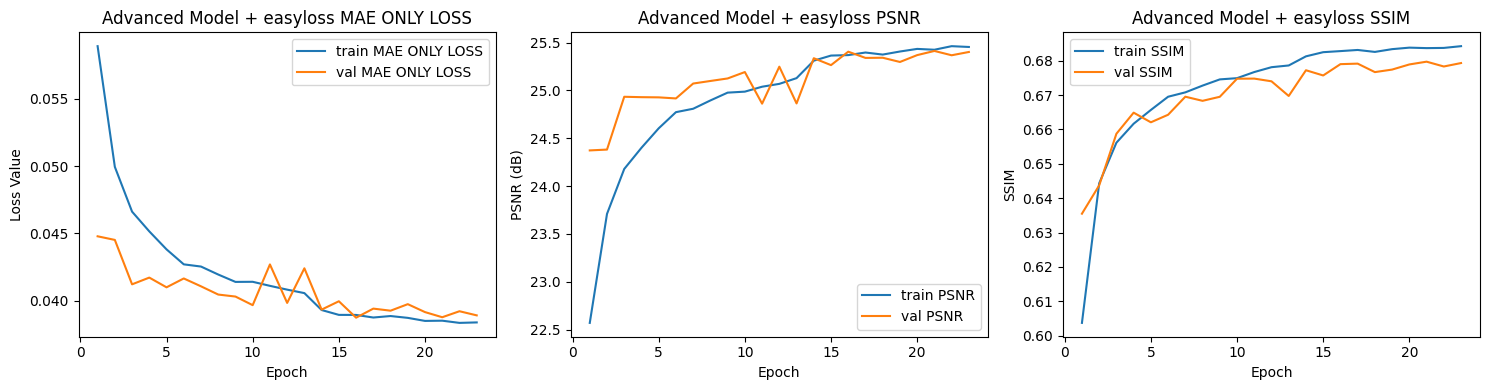

In [ ]:
# --- 14.3 Plots Advance U-Net with MAE
plot_three_metrics(history_adv_easyloss, title_prefix="Advanced Model + easyloss")

In [ ]:
# --- 14.4 Save Advance U-Net with MAE
model_adv_easyloss.save('model_adv_easyloss_full.keras')

In [ ]:
# --- 15.1 Advance U-Net with MAE + Perceptual Block2
# This model uses the advanced U-Net and a combined loss including perceptual loss derived from early-level features (VGG block2_conv2).
model_adv_b2.compile(
    optimizer=keras.optimizers.Adam(5e-4),
    loss=sr_loss_block2,
    metrics=[
        perceptual_block2,
        pixel_loss,
        psnr_metric,
        ssim_metric
    ]
)

In [ ]:
# --- 15.2 Train Advance U-Net with MAE + Perceptual Block2
history_adv_b2 = model_adv_b2.fit(train_ds,
                                  validation_data=val_ds,
                                  epochs=EPOCHS,
                                  callbacks=callbacks_adv_b2
)

Epoch 1/50
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.4587 - mean_absolute_error: 0.0696 - perceptual_block2: 77.8195 - psnr_metric: 21.3065 - ssim_metric: 0.5278
Epoch 1: val_loss improved from inf to 0.39563, saving model to checkpoint_adv_block2.keras
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 205s 109ms/step - loss: 0.4587 - mean_absolute_error: 0.0696 - perceptual_block2: 77.8167 - psnr_metric: 21.3071 - ssim_metric: 0.5278 - val_loss: 0.3956 - val_mean_absolute_error: 0.0474 - val_perceptual_block2: 69.6415 - val_psnr_metric: 23.9828 - val_ssim_metric: 0.6099 - learning_rate: 5.0000e-04
Epoch 2/50
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.3946 - mean_absolute_error: 0.0539 - perceptual_block2: 68.1469 - psnr_metric: 23.2114 - ssim_metric: 0.6151
Epoch 2: val_loss improved from 0.39563 to 0.38114, saving model to checkpoint_adv_block2.keras
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 183s 108ms/step - loss: 0.3946 - mean_absolute_error: 0.0539 - perceptual_block2: 68.1468 - psnr_met

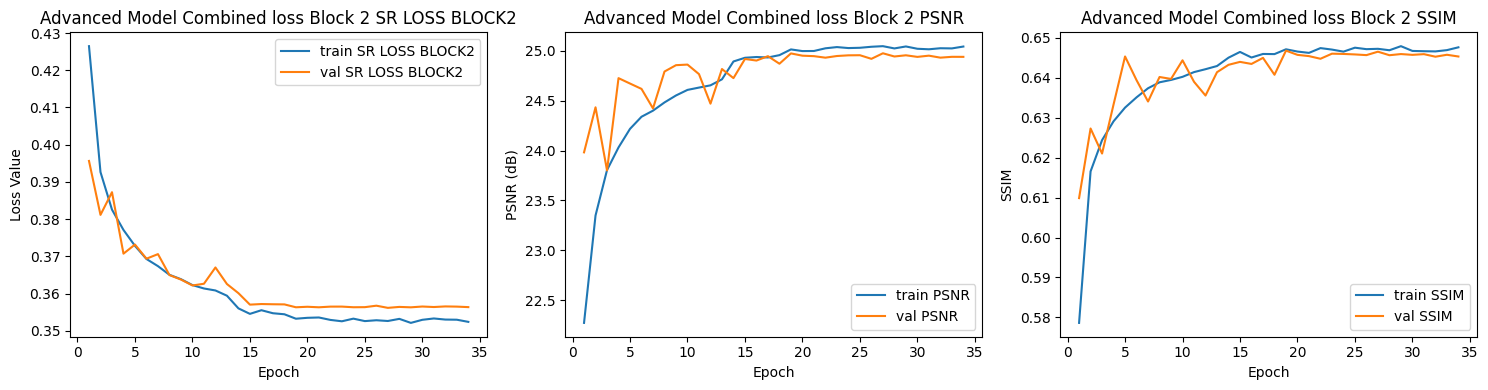

In [ ]:
# --- 15.3 Plot Advance U-Net with MAE + Perceptual Block5
plot_three_metrics(history_adv_b2, title_prefix="Advanced Model Combined loss Block 2")

In [ ]:
# --- 15.4 Save Advance U-Net with MAE + Perceptual Block2
model_adv_b2.save('model_adv_block2_full.keras')

In [ ]:
# --- 16.1 Advance U-Net with MAE + Perceptual Block5
# This model uses the advanced U-Net and a combined loss including perceptual loss derived from high-level features (VGG block5_conv4).
model_adv_b5.compile(
    optimizer=keras.optimizers.Adam(5e-4),
    loss=sr_loss_block5,
    metrics=[
        perceptual_block5,
        pixel_loss,
        psnr_metric,
        ssim_metric
    ]
)

In [ ]:
# --- 16.2 Train Advance U-Net with MAE + Perceptual Block5
history_adv_b5 = model_adv_b5.fit(train_ds,
                                  validation_data=val_ds,
                                  epochs=EPOCHS,
                                  callbacks=callbacks_adv_b5
)

Epoch 1/50
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0707 - mean_absolute_error: 0.0657 - perceptual_block5: 1.0105 - psnr_metric: 21.7653 - ssim_metric: 0.5619
Epoch 1: val_loss improved from inf to 0.04786, saving model to checkpoint_adv_block5.keras
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 340s 186ms/step - loss: 0.0707 - mean_absolute_error: 0.0657 - perceptual_block5: 1.0105 - psnr_metric: 21.7658 - ssim_metric: 0.5619 - val_loss: 0.0479 - val_mean_absolute_error: 0.0437 - val_perceptual_block5: 0.8361 - val_psnr_metric: 24.4984 - val_ssim_metric: 0.6434 - learning_rate: 5.0000e-04
Epoch 2/50
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0571 - mean_absolute_error: 0.0524 - perceptual_block5: 0.9232 - psnr_metric: 23.4164 - ssim_metric: 0.6399
Epoch 2: val_loss improved from 0.04786 to 0.04757, saving model to checkpoint_adv_block5.keras
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 312s 183ms/step - loss: 0.0571 - mean_absolute_error: 0.0524 - perceptual_block5: 0.9231 - psnr_metric

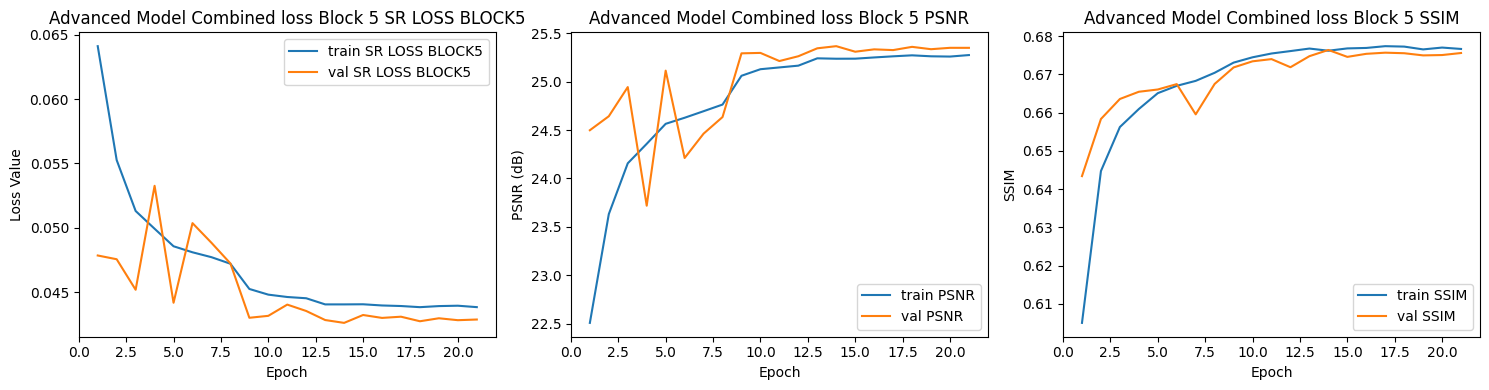

In [ ]:
# --- 16.3 Plot Advance U-Net with MAE + Perceptual Block5
plot_three_metrics(history_adv_b5, title_prefix="Advanced Model Combined loss Block 5")

In [ ]:
# --- 16.4 Save Advance U-Net with MAE + Perceptual Block5
model_adv_b5.save('model_adv_block5_full.keras')

In [ ]:
# --- 17.1 Advance U-Net with MAE + Perceptual Block5
# This model uses the advanced U-Net and a combined loss including perceptual loss derived from high-level features (VGG block5_conv4).
# It changes from the previous one in the loss: the alpha coefficient of the perceptual loss is now 0.02 (in the previous one it was 0.005).
model_adv_b5_alpha.compile(
    optimizer=keras.optimizers.Adam(5e-4),
    loss=sr_loss_block5_alpha,
    metrics=[
        perceptual_block5,
        pixel_loss,
        psnr_metric,
        ssim_metric
    ]
)

In [ ]:
# --- 17.2 Train Advance U-Net with MAE + Perceptual Block5
history_adv_b5_alpha = model_adv_b5_alpha.fit(train_ds,
                                              validation_data=val_ds,
                                              epochs=EPOCHS,
                                              callbacks=callbacks_adv_b5_alpha
)

Epoch 1/50
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0850 - mean_absolute_error: 0.0655 - perceptual_block5: 0.9706 - psnr_metric: 21.8190 - ssim_metric: 0.5651
Epoch 1: val_loss improved from inf to 0.06302, saving model to checkpoint_adv_block5_alpha.keras
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 335s 186ms/step - loss: 0.0849 - mean_absolute_error: 0.0655 - perceptual_block5: 0.9706 - psnr_metric: 21.8195 - ssim_metric: 0.5651 - val_loss: 0.0630 - val_mean_absolute_error: 0.0470 - val_perceptual_block5: 0.7990 - val_psnr_metric: 24.0710 - val_ssim_metric: 0.6415 - learning_rate: 5.0000e-04
Epoch 2/50
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0699 - mean_absolute_error: 0.0520 - perceptual_block5: 0.8968 - psnr_metric: 23.4449 - ssim_metric: 0.6407
Epoch 2: val_loss improved from 0.06302 to 0.05779, saving model to checkpoint_adv_block5_alpha.keras
1700/1700 ━━━━━━━━━━━━━━━━━━━━ 312s 183ms/step - loss: 0.0699 - mean_absolute_error: 0.0520 - perceptual_block5: 0.8968 -

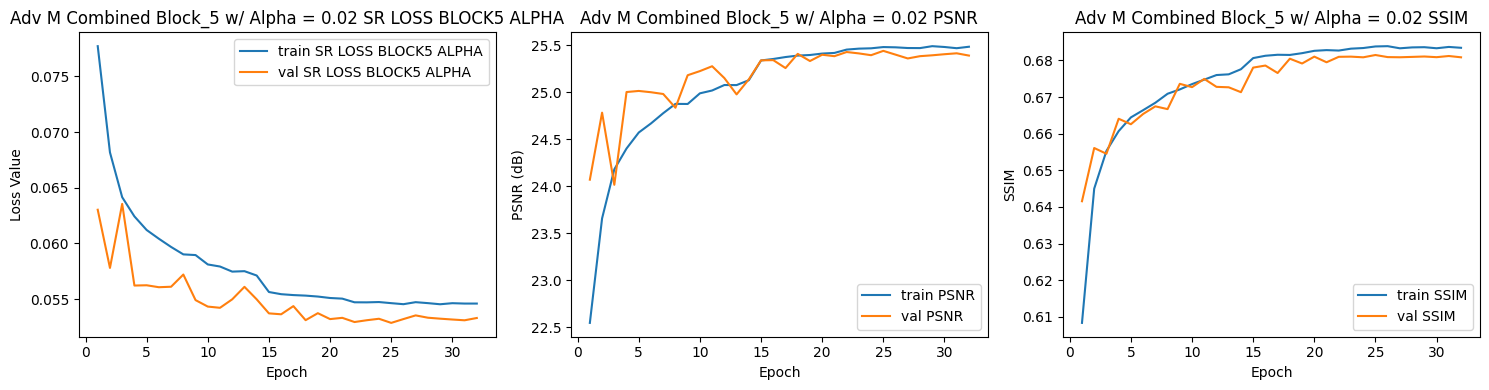

In [ ]:
# --- 17.3 Plot Advance U-Net with MAE + Perceptual Block5
plot_three_metrics(history_adv_b5_alpha, title_prefix="Adv M Combined Block_5 w/ Alpha = 0.02")

In [ ]:
# --- 17.4 Save Advance U-Net with MAE + Perceptual Block5
model_adv_b5_alpha.save('model_adv_block5_alpha_full.keras')

## Model Evaluation and Inference
This section loads the trained models, evaluates their performance on the test dataset using **quantitative** metrics, and then performs **qualitative** visual inference on a random image patch.

In [ ]:
# --- 18 Load models weights + Evaluation
# 18.1 dictionary for loading models with their metrics
model_base_first1_loaded = load_model(
    'model_base_first_full1.keras',
    custom_objects={
      'mae_only_loss': mae_only_loss,
      'psnr_metric': psnr_metric,
      'ssim_metric': ssim_metric
    }
)

model_adv_easyloss_loaded = load_model(
    'model_adv_easyloss_full.keras',
    custom_objects={
      'mae_only_loss': mae_only_loss,
      'psnr_metric': psnr_metric,
      'ssim_metric': ssim_metric

    }
)

model_adv_b2_loaded = load_model(
    'model_adv_block2_full.keras',
    custom_objects={
        'sr_loss_block2': sr_loss_block2,
        'perceptual_block2': perceptual_block2,
        'mae_only_loss': mae_only_loss,
        'psnr_metric': psnr_metric,
        'ssim_metric': ssim_metric
    }
)

model_adv_b5_loaded = load_model(
    'model_adv_block5_full.keras',
    custom_objects={
        'sr_loss_block5': sr_loss_block5,
        'perceptual_block5': perceptual_block5,
        'mae_only_loss': mae_only_loss,
        'psnr_metric': psnr_metric,
        'ssim_metric': ssim_metric
    }
)

model_adv_b5_alpha_loaded = load_model(
    'model_adv_block5_alpha_full.keras',
    custom_objects={
        'sr_loss_block5_alpha': sr_loss_block5_alpha,
        'perceptual_block5': perceptual_block5,
        'mae_only_loss': mae_only_loss,
        'psnr_metric': psnr_metric,
        'ssim_metric': ssim_metric
    }
)

# 18.2 Evaluation of each model on the test data
res_base_first1 = model_base_first1_loaded.evaluate(test_ds, return_dict=True)
res_adv_easyloss = model_adv_easyloss_loaded.evaluate(test_ds, return_dict=True)
res_adv_b2 = model_adv_b2_loaded.evaluate(test_ds, return_dict=True)
res_adv_b5 = model_adv_b5_loaded.evaluate(test_ds, return_dict=True)
res_adv_b5_alpha = model_adv_b5_alpha_loaded.evaluate(test_ds, return_dict=True)

375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - loss: 0.0359 - mae_only_loss: 0.0359 - psnr_metric: 25.8424 - ssim_metric: 0.7021
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - loss: 0.0384 - mae_only_loss: 0.0384 - psnr_metric: 25.4811 - ssim_metric: 0.6826
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - loss: 0.3557 - mean_absolute_error: 0.0410 - perceptual_block2: 62.9269 - psnr_metric: 25.0410 - ssim_metric: 0.6500
375/375 ━━━━━━━━━━━━━━━━━━━━ 40s 95ms/step - loss: 0.0423 - mean_absolute_error: 0.0384 - perceptual_block5: 0.7694 - psnr_metric: 25.4461 - ssim_metric: 0.6802
375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 98ms/step - loss: 0.0525 - mean_absolute_error: 0.0383 - perceptual_block5: 0.7117 - psnr_metric: 25.5153 - ssim_metric: 0.6850


In [ ]:
#--- 19 Evaluation
print("Evaluation simple U-Net + base loss (mae_only_loss)")
print(f"Test MAE (Loss): {res_base_first1['mae_only_loss']:.4f}")
print(f"Test PSNR: {res_base_first1['psnr_metric']:.4f}")
print(f"Test SSIM: {res_base_first1['ssim_metric']:.4f}")
print("\n")
print("Evaluation advanced U-Net + base loss (mae_only_loss)")
print(f"Test MAE (Loss): {res_adv_easyloss['mae_only_loss']:.4f}")
print(f"Test PSNR: {res_adv_easyloss['psnr_metric']:.4f}")
print(f"Test SSIM: {res_adv_easyloss['ssim_metric']:.4f}")
print("\n")
print("Evaluation advanced U-Net + perceptual loss (sr_loss) -- BLOCK 2 --")
print(f"Test Perceptual Loss: {res_adv_b2['perceptual_block2']:.4f}")
print(f"Test MAE (loss): {res_adv_b2['mean_absolute_error']:.4f}")
print(f"Test Combined Loss (Perceptual Loss + MAE loss): {res_adv_b2['loss']:.4f}")
print(f"Test PSNR: {res_adv_b2['psnr_metric']:.4f}")
print(f"Test SSIM: {res_adv_b2['ssim_metric']:.4f}")
print("\n")
print("Evaluation advanced U-Net + perceptual loss (sr_loss) -- BLOCK 5 --")
print(f"Test Perceptual Loss: {res_adv_b5['perceptual_block5']:.4f}")
print(f"Test MAE (loss): {res_adv_b5['mean_absolute_error']:.4f}")
print(f"Test Combined Loss (Perceptual Loss + MAE loss): {res_adv_b5['loss']:.4f}")
print(f"Test PSNR: {res_adv_b5['psnr_metric']:.4f}")
print(f"Test SSIM: {res_adv_b5['ssim_metric']:.4f}")
print("\n")
print("Evaluation advanced U-Net + perceptual loss (sr_loss) -- BLOCK 5 -- & Alpha = 0.02")
print(f"Test Perceptual Loss: {res_adv_b5_alpha['perceptual_block5']:.4f}")
print(f"Test MAE (loss): {res_adv_b5_alpha['mean_absolute_error']:.4f}")
print(f"Test Combined Loss (Perceptual Loss + MAE loss): {res_adv_b5_alpha['loss']:.4f}")
print(f"Test PSNR: {res_adv_b5_alpha['psnr_metric']:.4f}")
print(f"Test SSIM: {res_adv_b5_alpha['ssim_metric']:.4f}")

Evaluation simple U-Net + base loss (mae_only_loss)
Test MAE (Loss): 0.0364
Test PSNR: 25.7761
Test SSIM: 0.6990


Evaluation advanced U-Net + base loss (mae_only_loss)
Test MAE (Loss): 0.0389
Test PSNR: 25.4123
Test SSIM: 0.6793


Evaluation advanced U-Net + perceptual loss (sr_loss) -- BLOCK 2 --
Test Perceptual Loss: 63.3269
Test MAE (loss): 0.0415
Test Combined Loss (Perceptual Loss + MAE loss): 0.3582
Test PSNR: 24.9760
Test SSIM: 0.6467


Evaluation advanced U-Net + perceptual loss (sr_loss) -- BLOCK 5 --
Test Perceptual Loss: 0.7761
Test MAE (loss): 0.0389
Test Combined Loss (Perceptual Loss + MAE loss): 0.0428
Test PSNR: 25.3774
Test SSIM: 0.6769


Evaluation advanced U-Net + perceptual loss (sr_loss) -- BLOCK 5 -- & Alpha = 0.02
Test Perceptual Loss: 0.7185
Test MAE (loss): 0.0387
Test Combined Loss (Perceptual Loss + MAE loss): 0.0531
Test PSNR: 25.4455
Test SSIM: 0.6817


In [ ]:
# --- 20 Preparation for the Patch Visualization

# 20.1 Select a random image from test data
sample_path_hr = random.choice(test_paths)
hr_full_image = tf.image.convert_image_dtype(
    tf.io.decode_jpeg(tf.io.read_file(sample_path_hr), channels=CH),
    tf.float32
)

# 20.2.1 Extract HR resolution patch by central cropping:
hr_patch_gt = tf.image.resize_with_crop_or_pad(hr_full_image, PATCH_H, PATCH_W)

# 20.3 Degrade HR Patch to generate LR Degrade
lr_patch_input = degrade(hr_patch_gt.numpy())

# 20.4 Model prediction by passing the LR patch through each trained model
sr_patch_predicted_simpl_U = model_base_first1_loaded.predict(lr_patch_input[None, ...])[0]
sr_patch_predicted_adv_easyloss = model_adv_easyloss_loaded.predict(lr_patch_input[None, ...])[0]
sr_patch_predicted_adv_block2 = model_adv_b2_loaded.predict(lr_patch_input[None, ...])[0]
sr_patch_predicted_adv_block5 = model_adv_b5_loaded.predict(lr_patch_input[None, ...])[0]
sr_patch_predicted_adv_block5_alpha = model_adv_b5_alpha_loaded.predict(lr_patch_input[None, ...])[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step


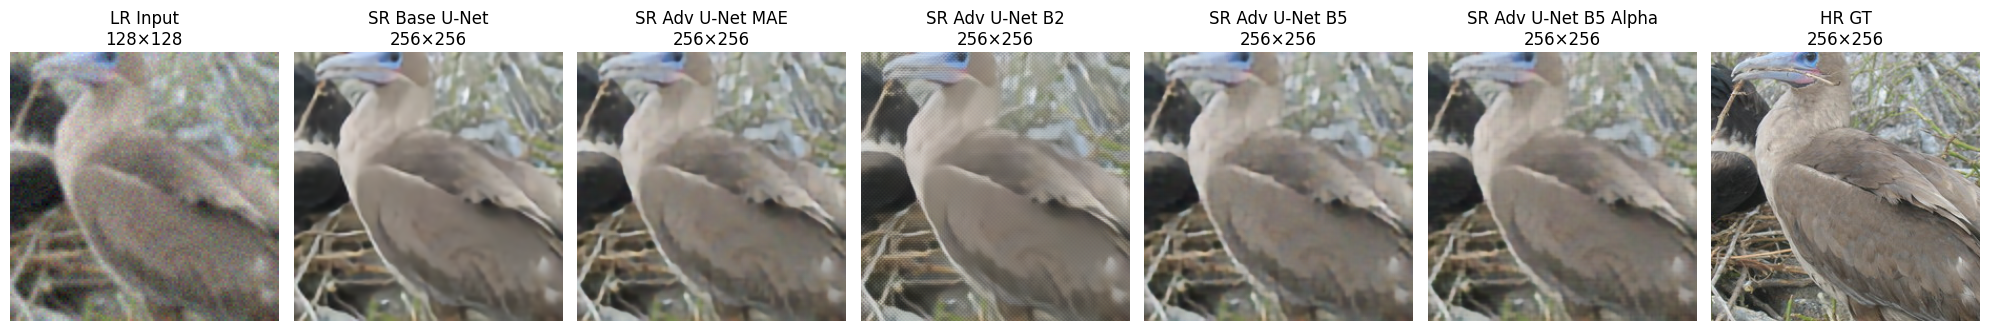

In [ ]:
# --- 21 Visualization of the Model Predicion
predictions = {
    "Base U-Net": sr_patch_predicted_simpl_U,
    "Adv U-Net MAE": sr_patch_predicted_adv_easyloss,
    "Adv U-Net B2": sr_patch_predicted_adv_block2,
    "Adv U-Net B5": sr_patch_predicted_adv_block5,
    "Adv U-Net B5 Alpha" : sr_patch_predicted_adv_block5_alpha
}

plt.figure(figsize=(20, 4))

# 21.1 LR Input
plt.subplot(1, 7, 1)
plt.title(f"LR Input\n{PATCH_LR_H}×{PATCH_LR_W}")
plt.imshow(lr_patch_input)
plt.axis('off')

# 21.2 Super-Resolution Base U-Net
plt.subplot(1, 7, 2)
plt.title(f"SR Base U-Net\n{PATCH_H}×{PATCH_W}")
plt.imshow(predictions["Base U-Net"])
plt.axis('off')

# 21.3 Super-Resolution Adv U-Net MAE
plt.subplot(1, 7, 3)
plt.title(f"SR Adv U-Net MAE\n{PATCH_H}×{PATCH_W}")
plt.imshow(predictions["Adv U-Net MAE"])
plt.axis('off')

# 21.4 Super-Resolution Adv U-Net B2
plt.subplot(1, 7, 4)
plt.title(f"SR Adv U-Net B2\n{PATCH_H}×{PATCH_W}")
plt.imshow(predictions["Adv U-Net B2"])
plt.axis('off')

# 21.5 Super-Resolution Adv U-Net B5
plt.subplot(1, 7, 5)
plt.title(f"SR Adv U-Net B5\n{PATCH_H}×{PATCH_W}")
plt.imshow(predictions["Adv U-Net B5"])
plt.axis('off')

# 21.6 Super-Resolution Adv U-Net B5 Alpha
plt.subplot(1, 7, 6)
plt.title(f"SR Adv U-Net B5 Alpha\n{PATCH_H}×{PATCH_W}")
plt.imshow(predictions["Adv U-Net B5 Alpha"])
plt.axis('off')

# 21.7 HR Ground Truth
plt.subplot(1, 7, 7)
plt.title(f"HR GT\n{PATCH_H}×{PATCH_W}")
plt.imshow(hr_patch_gt.numpy())
plt.axis('off')

plt.tight_layout()
plt.show()

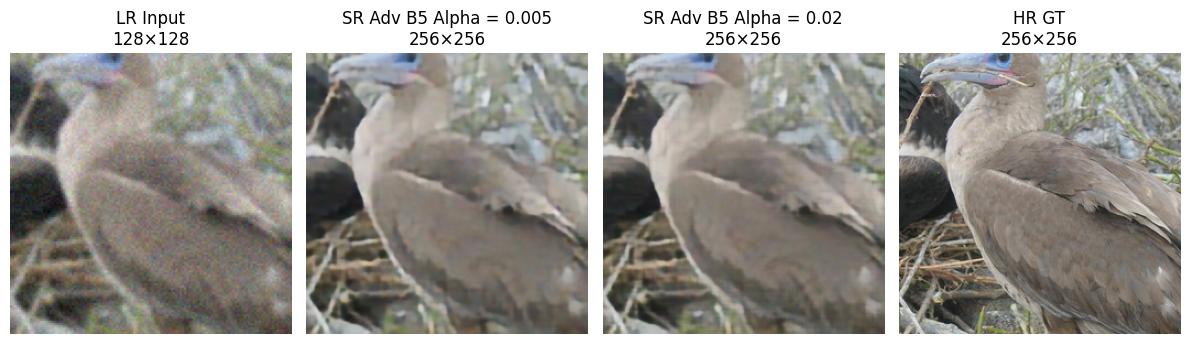

In [ ]:
# --- 22 Visualization alpha = 0.005 & alpha = 0.02
plt.figure(figsize=(12,4))

# 22.1 LR Input
plt.subplot(1, 4, 1)
plt.title(f"LR Input\n{PATCH_LR_H}×{PATCH_LR_W}")
plt.imshow(lr_patch_input)
plt.axis('off')

# 22.1 Adv U-Net B5 Alpha = 0.005
plt.subplot(1, 4, 2)
plt.title(f"SR Adv B5 Alpha = 0.005\n{PATCH_H}×{PATCH_W}")
plt.imshow(predictions["Adv U-Net B5"])
plt.axis('off')

# 22.1 Adv U-Net B5 Alpha = 0.02
plt.subplot(1, 4, 3)
plt.title(f"SR Adv B5 Alpha = 0.02\n{PATCH_H}×{PATCH_W}")
plt.imshow(predictions["Adv U-Net B5 Alpha"])
plt.axis('off')

# 22.1 HR Ground Truth
plt.subplot(1, 4, 4)
plt.title(f"HR GT\n{PATCH_H}×{PATCH_W}")
plt.imshow(hr_patch_gt.numpy())
plt.axis('off')

plt.tight_layout()
plt.show()